# Testing bias metrics and mitigation algorithms on the Adult Income dataset

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from Sampler import Sampler
from utility import *

In [95]:
def load_dataset():
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation','relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    adult_df = pd.read_csv('adult/adult.data', names=column_names)
    adult_df.drop(adult_df[(adult_df['race'] != ' Black') & (adult_df['race'] != ' White')].index,inplace=True)
    adult_df.loc[adult_df['native-country'] == ' ?', 'native-country'] = 'Not known'
    return adult_df

## Dataset description

The Adult Income dataset contains informations about the income of people extracted from the 1994 Census database. Prediction task is to determine whether a person makes over 50K a year. It has been shown that the dataset is bias in favor of white men and against women and people of other races.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [96]:
adult_df = load_dataset()
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [97]:
adult_df.shape

(30940, 15)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


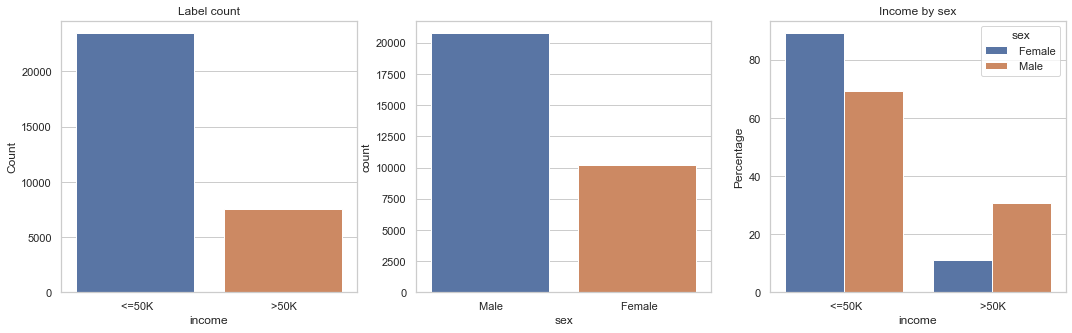

In [98]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
sns.barplot(x='income', y='percentage', 
            data=adult_df[['sex','income']].groupby('sex')['income'].value_counts(normalize=True).rename('percentage').mul(100).reset_index(),
            hue='sex',
            ax=ax[2])
sns.countplot(x='income', data=adult_df, ax=ax[0])
sns.countplot(x='sex', data=adult_df, ax=ax[1])
ax[2].set(ylabel='Percentage', title="Income by sex")
ax[0].set(ylabel='Count', title="Label count")
plt.show()

So we are in an **Unbalanced Bias Dataset** case.

## Dataset transformation

In [99]:
lab_enc = LabelEncoder()
ord_enc = OrdinalEncoder()

In [100]:
adult_df['age_class'] = pd.cut(adult_df['age'],
                               bins=[0,9,19,29,39,49,59,69,99],
                               labels=['age<10','age between 10 and 20','age between 20 and 30',
                                       'age between 30 and 40','age between 40 and 50',
                                       'age between 50 and 60','age between 60 and 70','age>70']
                              )
adult_df['hour-per-week-class'] = pd.cut(adult_df['hours-per-week'],
                               bins=[0,9,19,29,39,49,99],
                               labels=['hour<10','hours between 10 and 20','hours between 20 and 30',
                                       'hours between 30 and 40','hour between 40 and 50',
                                       'hour>70']
                              )
adult_df.drop(labels=['hours-per-week','workclass','fnlwgt','capital-gain','capital-loss','age','education-num'],
              axis=1,inplace=True)
adult_df = adult_df.join(pd.get_dummies(adult_df['education'])).drop('education',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['marital-status'])).drop('marital-status',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['occupation'])).drop('occupation',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['relationship'])).drop('relationship',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['native-country'])).drop('native-country',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['age_class'])).drop('age_class',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['hour-per-week-class'])).drop('hour-per-week-class',axis=1)
adult_df['income'] = lab_enc.fit_transform(adult_df['income'])
adult_df[['sex','race']] = ord_enc.fit_transform(adult_df[['sex','race']])

# Bias dataset and classification metrics

Create a StructuredDataset object to which apply fairness metrics and methods

In [178]:
unprivileged_group = [{'sex': 0}]
privileged_group = [{'sex': 1}]

In [179]:
data = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=adult_df, label_names=['income'], protected_attribute_names=['sex'])

## Bias Dataset

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.8104
Statistical parity difference: -0.3151
Disparate impact: 0.3490
Average odds difference: -0.1671
Equal opportunity difference: -0.1184
Theil index: 0.0830


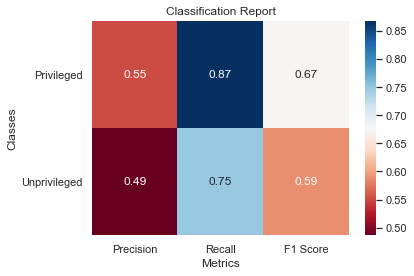

In [184]:
class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    data, privileged_group, unprivileged_group)

## Reweighing

In [ ]:
rw_data = data.copy()
rw = Reweighing(unprivileged_group, privileged_group)

In [ ]:
rw_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_data, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


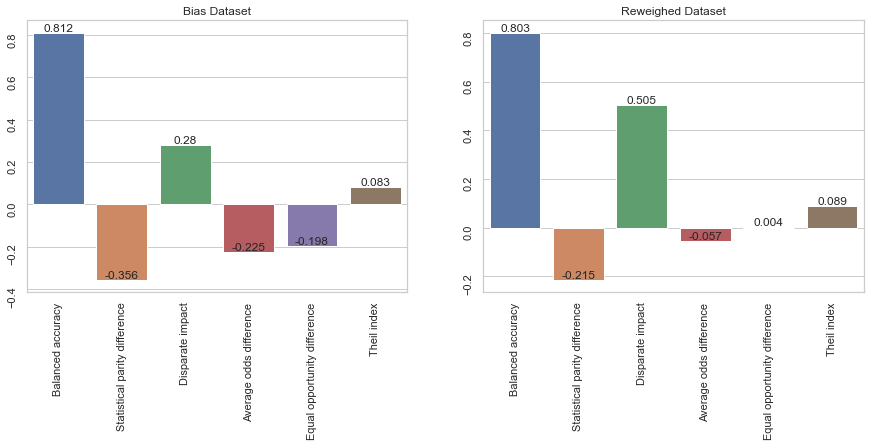

In [183]:
plot_metrics_comparison(class_metrics, rw_class, "Bias Dataset", "Reweighed Dataset")
plt.show()

## Disparate Impact Remover

First we will apply the DIR to the One Hot Encoded dataset and see if it has some effects on the bias mitigation

In [107]:
dir_data = data.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


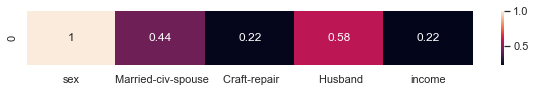

In [108]:
df = dir_data.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


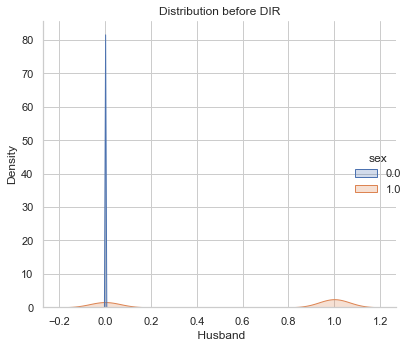

In [109]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.tight_layout()
plt.savefig('dir_cat_bf.pdf')
plt.show()

Apply DIR and check correlation changes:

In [110]:
di = DisparateImpactRemover(sensitive_attribute='sex')
dir_data_trans = di.fit_transform(dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


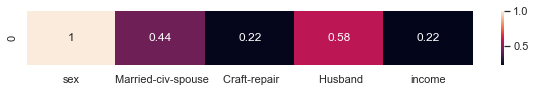

In [111]:
df = dir_data_trans.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


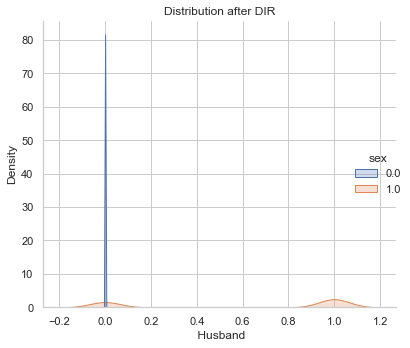

In [112]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
plt.tight_layout()
plt.savefig('dir_cat_aft.pdf')
plt.show()

### Classification Metrics

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.8101
Statistical parity difference: -0.3170
Disparate impact: 0.3470
Average odds difference: -0.1690
Equal opportunity difference: -0.1201
Theil index: 0.0831


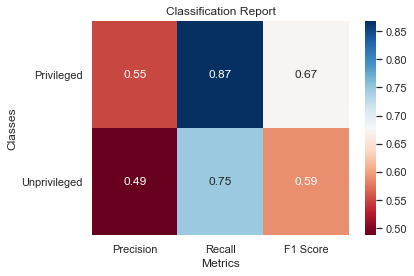

In [113]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


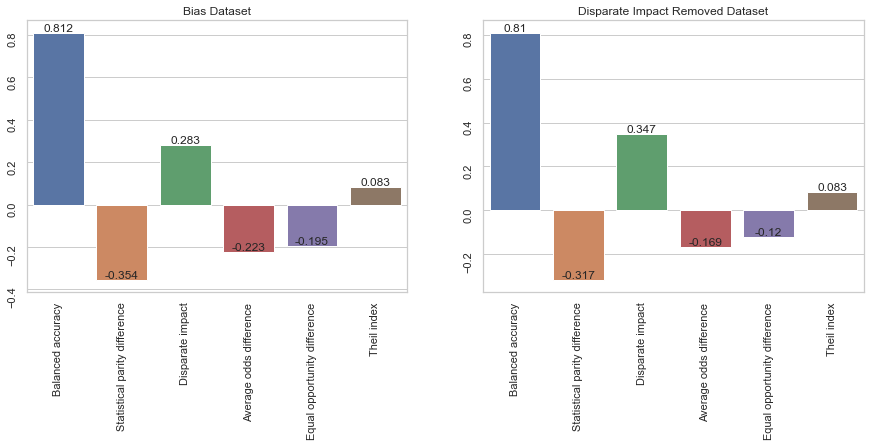

In [114]:
plot_metrics_comparison(class_metrics, dir_class, 'Bias Dataset', 'Disparate Impact Removed Dataset')
plt.show()

## Modified Reweighing (Sampling)

In [188]:
sampled_data = data.copy()
sampler = Sampler(round_level=3)

### Classification Metrics

### Dataset Metrics:

Disparate Impact: 0.9990
Statistical Parity: -0.0002




### Classification Metrics:

Balanced accuracy: 0.7992
Statistical parity difference: -0.1900
Disparate impact: 0.5520
Average odds difference: -0.0303
Equal opportunity difference: 0.0327
Theil index: 0.0906


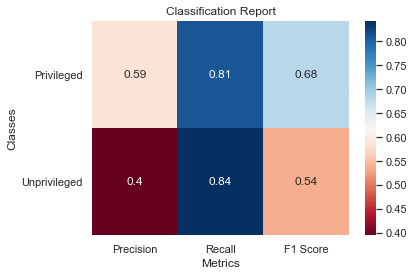

In [189]:
sampled_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_data, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


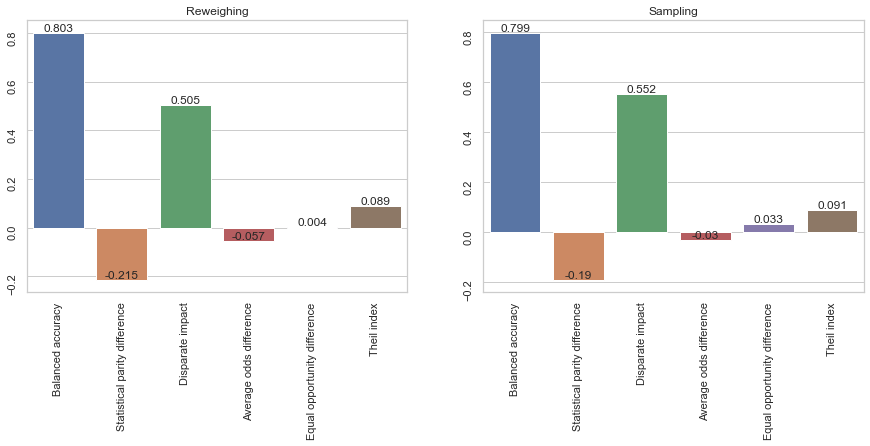

In [190]:
plot_metrics_comparison(rw_class, sampled_metrics, 'Reweighing', 'Sampling')
plt.show()

## Reweighing vs DIR vs Sampling

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset,-0.2226,0.8118,0.2829,-0.1946,-0.3543,0.0827
DIR Dataset,-0.1690,0.8101,0.3470,-0.1201,-0.3170,0.0831
Reweighed Dataset,-0.0346,0.8004,0.5506,0.0244,-0.1919,0.0899
Sampled Dataset,-0.0333,0.7994,0.5464,0.0290,-0.1923,0.0907


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


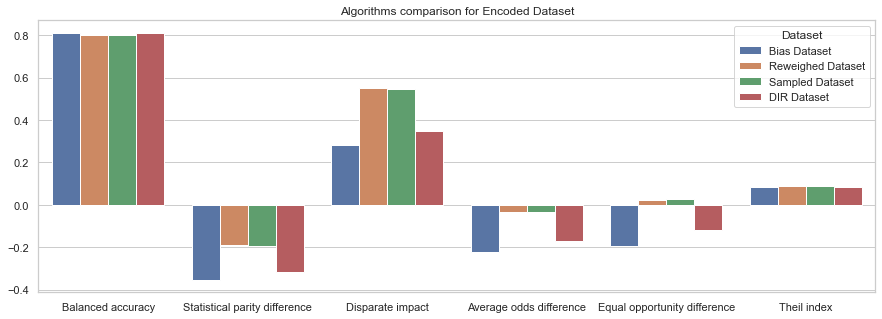

In [119]:
plot_syntesis(merge_datasets({
    'Bias Dataset': class_metrics,
    'Reweighed Dataset': rw_class,
    'Sampled Dataset': sampled_metrics,
    'DIR Dataset': dir_class,
}), "Algorithms comparison for Encoded Dataset")
plt.show()

# Test with numerical data

In [120]:
df = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 
             'marital-status', 'occupation', 'relationship', 'native-country','race']
df.drop(df[drop_cols], axis=1, inplace=True)
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['income'] = le.fit_transform(df['income'])
df

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income
0,39,13,1,2174,0,40,0
1,50,13,1,0,0,13,0
2,38,9,1,0,0,40,0
3,53,7,1,0,0,40,0
4,28,13,0,0,0,40,0
...,...,...,...,...,...,...,...
32556,27,12,0,0,0,38,0
32557,40,9,1,0,0,40,1
32558,58,9,0,0,0,40,0
32559,22,9,1,0,0,20,0


## Bias Dataset

In [121]:
df_bin = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=df, label_names=['income'], protected_attribute_names=['sex'])

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.7616
Statistical parity difference: -0.3605
Disparate impact: 0.2358
Average odds difference: -0.3095
Equal opportunity difference: -0.3664
Theil index: 0.1090


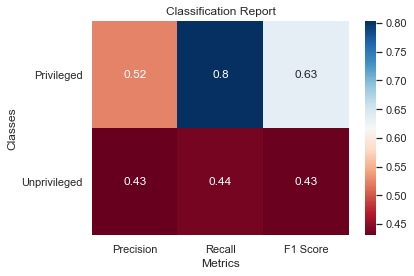

In [122]:
df_ord_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                        df_bin, privileged_group, unprivileged_group)

## Reweighing

In [123]:
rw = Reweighing(unprivileged_group, privileged_group)
df_bin_rw = df_bin.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7367
Statistical parity difference: -0.0888
Disparate impact: 0.7671
Average odds difference: -0.0072
Equal opportunity difference: -0.0249
Theil index: 0.1209


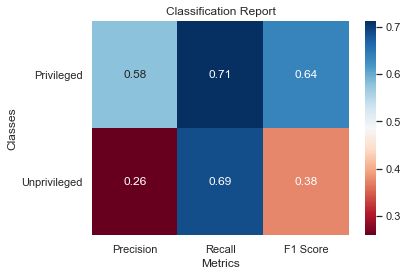

In [124]:
rw_ord_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    df_bin_rw, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


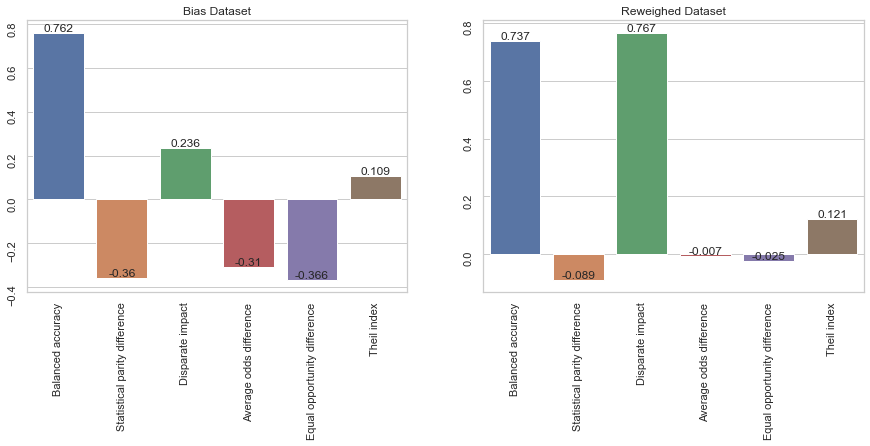

In [125]:
plot_metrics_comparison(df_ord_class, rw_ord_class, 'Bias Dataset', 'Reweighed Dataset')
plt.show()

## DIR

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


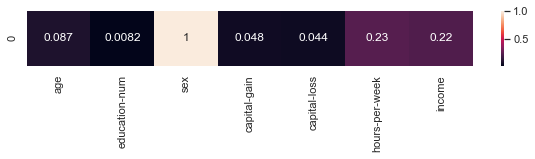

In [126]:
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


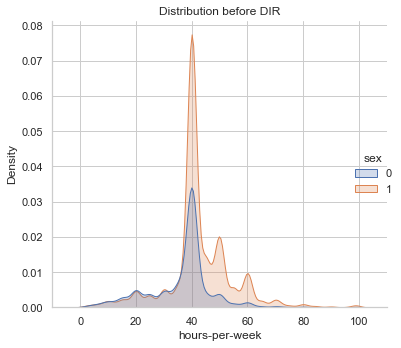

In [127]:
sns.displot(data=df, x='hours-per-week', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.tight_layout()
plt.savefig('dir_num_bf.pdf')
plt.show()

In [128]:
df_dir = df_bin.copy()
scaler = MinMaxScaler(copy=False)
df_dir.features = scaler.fit_transform(df_bin.features)

In [129]:
di = DisparateImpactRemover(sensitive_attribute='sex')
df_dir = di.fit_transform(df_bin)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


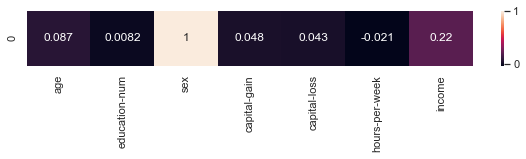

In [130]:
df = df_dir.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


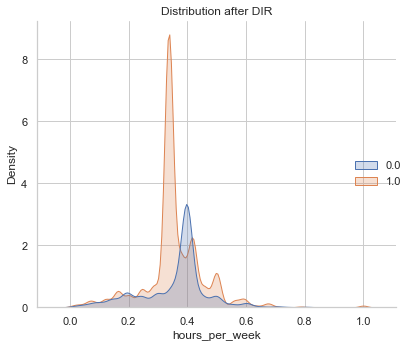

In [131]:
ax = sns.displot(x=df_dir.features[:,5], hue=df_dir.features[:,2], kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
ax.set(xlabel='hours_per_week')
plt.tight_layout()
plt.savefig('dir_num_aft.pdf')
plt.show()

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.7317
Statistical parity difference: -0.0635
Disparate impact: 0.8305
Average odds difference: 0.0145
Equal opportunity difference: -0.0069
Theil index: 0.1227


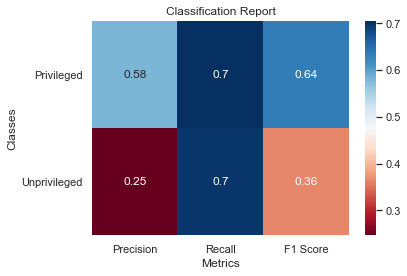

In [132]:
dir_ord_class = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                         df_dir, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


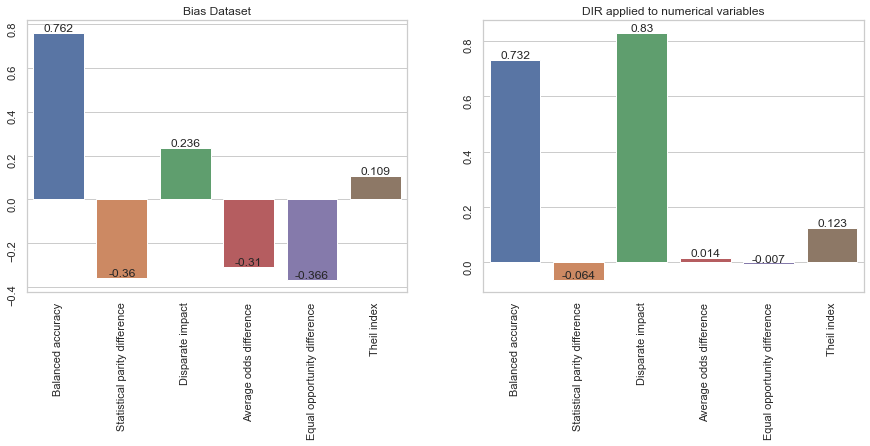

In [133]:
plot_metrics_comparison(df_ord_class, dir_ord_class, 'Bias Dataset', 'DIR applied to numerical variables')
plt.show()

## Modified Reweighing (Sampling)

In [134]:
sampler = Sampler(round_level=2)
sampled_num = df_bin.copy()

### Dataset Metrics:

Disparate Impact: 0.9854
Statistical Parity: -0.0036




### Classification Metrics:

Balanced accuracy: 0.7373
Statistical parity difference: -0.0968
Disparate impact: 0.7464
Average odds difference: -0.0181
Equal opportunity difference: -0.0396
Theil index: 0.1207


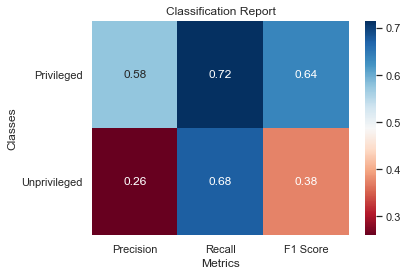

In [135]:
sampled_num_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_num, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


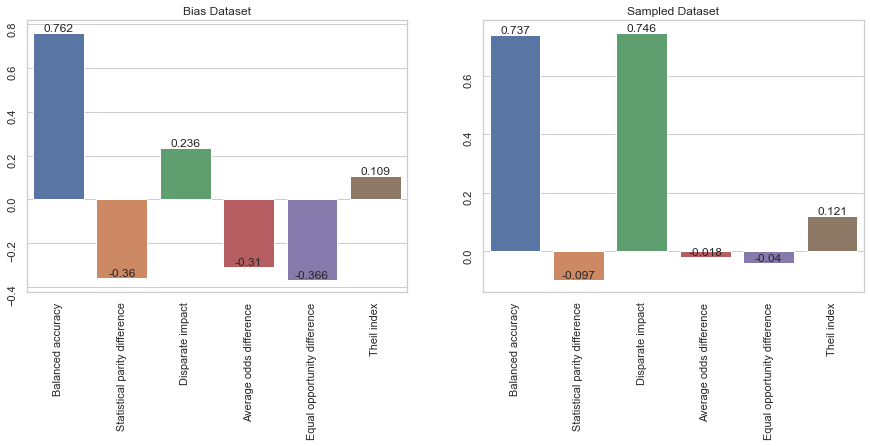

In [136]:
plot_metrics_comparison(df_ord_class, sampled_num_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs DIR vs Sampling

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset,-0.3095,0.7616,0.2358,-0.3664,-0.3605,0.1090
DIR Dataset,0.0145,0.7317,0.8305,-0.0069,-0.0635,0.1227
Reweighed Dataset,-0.0072,0.7367,0.7671,-0.0249,-0.0888,0.1209
Sampled Dataset,-0.0181,0.7373,0.7464,-0.0396,-0.0968,0.1207


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


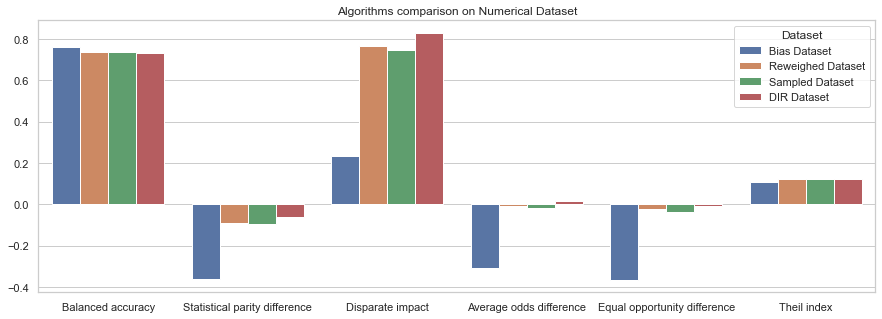

In [137]:
plot_syntesis(merge_datasets({
    'Bias Dataset': df_ord_class,
    'Reweighed Dataset': rw_ord_class,
    'Sampled Dataset': sampled_num_metrics,
    'DIR Dataset': dir_ord_class,
}), 'Algorithms comparison on Numerical Dataset')
plt.show()

# Reweighing + DIR

## Dataset with One Hot Encoded attributes

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


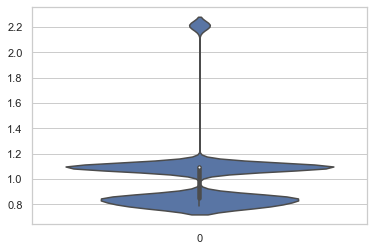

In [138]:
rw_dir_enc = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_dir_enc = rw.fit_transform(rw_dir_enc)
sns.violinplot(data=rw_dir_enc.instance_weights)
plt.show()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.8007
Statistical parity difference: -0.0872
Disparate impact: 0.7817
Average odds difference: -0.0551
Equal opportunity difference: 0.0070
Theil index: 0.0884


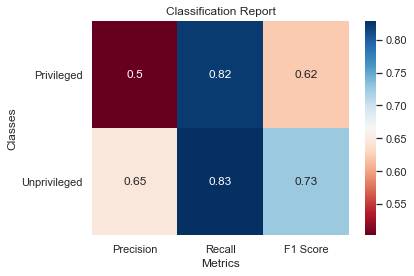

In [139]:
rw_dir_enc_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir_enc, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


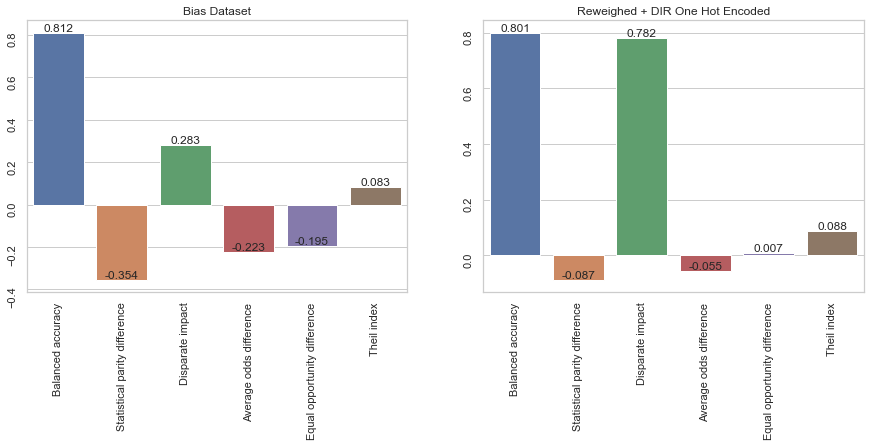

In [140]:
plot_metrics_comparison(class_metrics, rw_dir_enc_score, 'Bias Dataset', 'Reweighed + DIR One Hot Encoded')
plt.show()

## Dataset with numerical attributes

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


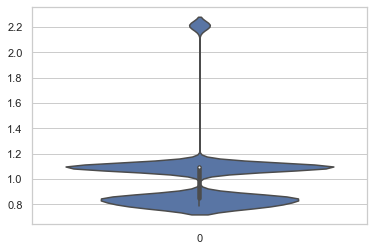

In [141]:
rw_dir_data = df_dir.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_dir_data = rw.fit_transform(rw_dir_data)
sns.violinplot(data= rw_dir_data.instance_weights)
plt.show()

In [142]:
metrics = compute_dataset_fairness_metrics(rw_dir_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7330
Statistical parity difference: 0.0313
Disparate impact: 1.0938
Average odds difference: 0.0217
Equal opportunity difference: 0.0027
Theil index: 0.1229


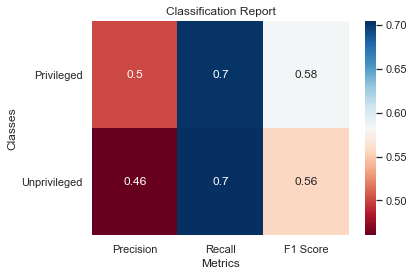

In [143]:
rw_dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_dir_data, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


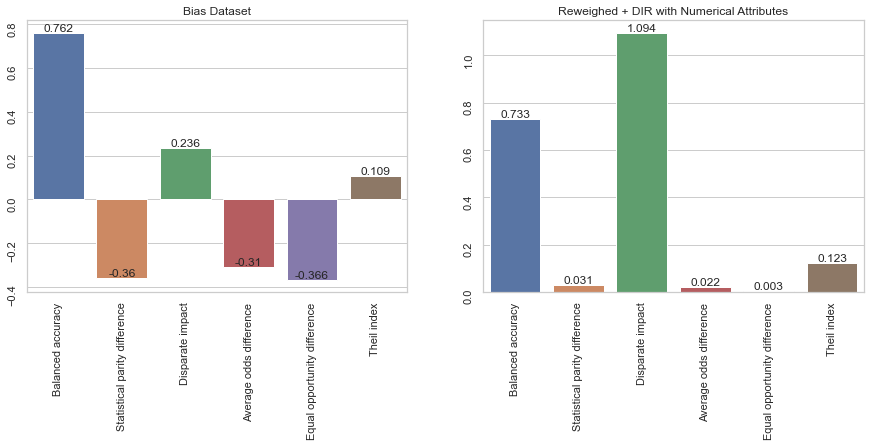

In [144]:
plot_metrics_comparison(df_ord_class, rw_dir_score, 'Bias Dataset', 'Reweighed + DIR with Numerical Attributes')
plt.show()

# Algorithms Comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset Numerical,-0.3095,0.7616,0.2358,-0.3664,-0.3605,0.1090
Bias Dataset One Hot,-0.2226,0.8118,0.2829,-0.1946,-0.3543,0.0827
Disparate Impact Remover Numerical,0.0145,0.7317,0.8305,-0.0069,-0.0635,0.1227
Disparate Impact Remover One Hot,-0.1690,0.8101,0.3470,-0.1201,-0.3170,0.0831
Reweighing + DIR Numerical,0.0217,0.7330,1.0938,0.0027,0.0313,0.1229
Reweighing + DIR One Hot,-0.0551,0.8007,0.7817,0.0070,-0.0872,0.0884
Reweighing Numerical,-0.0072,0.7367,0.7671,-0.0249,-0.0888,0.1209
Reweighing One Hot,-0.0346,0.8004,0.5506,0.0244,-0.1919,0.0899
Sampled Numerical,-0.0181,0.7373,0.7464,-0.0396,-0.0968,0.1207


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


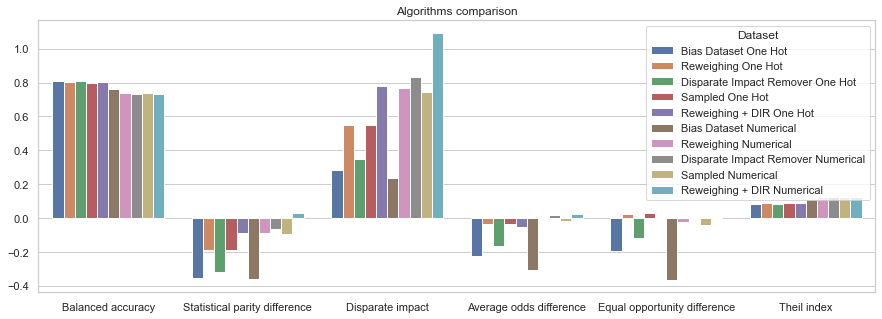

In [145]:
plot_syntesis(merge_datasets({
    'Bias Dataset One Hot': class_metrics,
    'Reweighing One Hot': rw_class,
    'Disparate Impact Remover One Hot': dir_class,
    'Sampled One Hot': sampled_metrics,
    'Reweighing + DIR One Hot': rw_dir_enc_score,
    'Bias Dataset Numerical': df_ord_class,
    'Reweighing Numerical': rw_ord_class,
    'Disparate Impact Remover Numerical': dir_ord_class,
    'Sampled Numerical': sampled_num_metrics,
    'Reweighing + DIR Numerical': rw_dir_score
}), 'Algorithms comparison')
plt.show()

# Test Adult with multiple sensitive attributes

In [146]:
df_2 = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 
             'marital-status', 'occupation', 'relationship', 'native-country']
df_2.drop(df_2[drop_cols], axis=1, inplace=True)
le = LabelEncoder()
df_2['sex'] = le.fit_transform(df['sex'])
df_2['race'] = le.fit_transform(df_2['race'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


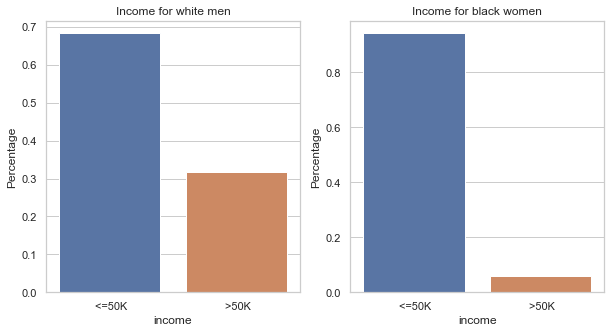

In [147]:
perc = (df_2[['sex','race','income']]
            .groupby(['sex','race'])['income']
            .value_counts(normalize=True)
            .rename('Percentage')
            .reset_index())
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
sns.barplot(data=perc[(perc['sex']==1)&(perc['race']==1)], x='income', y='Percentage', ax=ax1)
sns.barplot(data=perc[(perc['sex']==0)&(perc['race']==0)], x='income', y='Percentage', ax=ax2)
ax1.set_title('Income for white men')
ax2.set_title('Income for black women')
plt.show()

In [148]:
df_2[(df_2['sex']==0)&(df_2['race']==0)].shape

(1555, 8)

In [149]:
df_2[(df_2['sex']==1)&(df_2['race']==1)].shape

(19174, 8)

In [150]:
df_2['income'] = le.fit_transform(df_2['income'])

In [151]:
privileged_group = [{'sex': 1, 'race': 1}]
unprivileged_group = [{'sex': 0, 'race': 0}]

## Test on bias dataset

In [152]:
df_2bin = BinaryLabelDataset(df=df_2, protected_attribute_names = ['sex', 'race'], label_names=['income'])

### Dataset Metrics:

Disparate Impact: 0.1822
Statistical Parity: -0.2597




### Classification Metrics:

Balanced accuracy: 0.7622
Statistical parity difference: -0.4514
Disparate impact: 0.0895
Average odds difference: -0.3858
Equal opportunity difference: -0.4499
Theil index: 0.1084


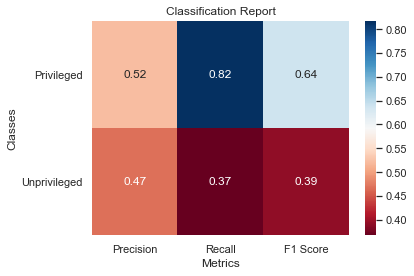

In [153]:
df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df_2bin, privileged_group, unprivileged_group)

## Reweighing

In [154]:
rw = Reweighing(unprivileged_group, privileged_group)
df2_rw = df_2bin.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7493
Statistical parity difference: -0.2465
Disparate impact: 0.3464
Average odds difference: -0.1362
Equal opportunity difference: -0.1491
Theil index: 0.1225


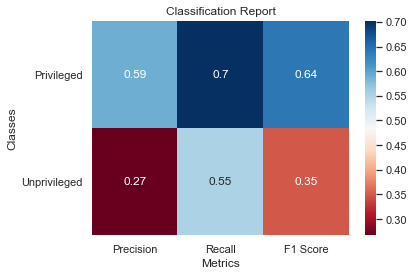

In [155]:
rw_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df2_rw, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


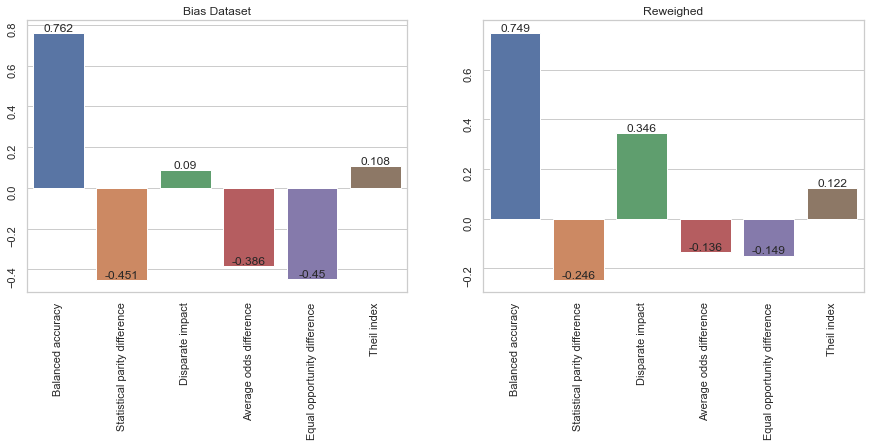

In [156]:
plot_metrics_comparison(df2_class, rw_df2_class, 'Bias Dataset', 'Reweighed')
plt.show()

## Modified Reweighing (Sampling)

In [171]:
sampled2 = df_2bin.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9868
Statistical Parity: -0.0032




### Classification Metrics:

Balanced accuracy: 0.7362
Statistical parity difference: -0.1568
Disparate impact: 0.5979
Average odds difference: -0.0249
Equal opportunity difference: -0.0153
Theil index: 0.1212


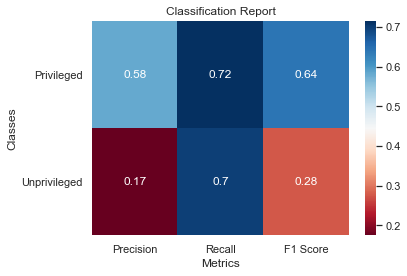

In [172]:
sampled_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled2, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


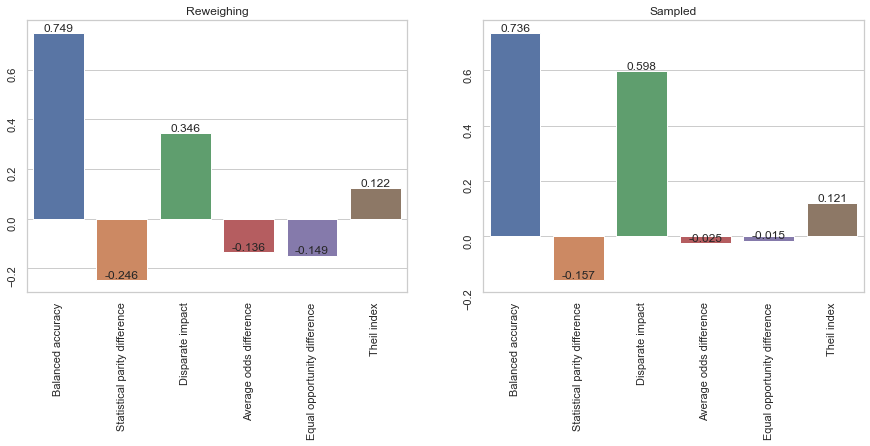

In [173]:
plot_metrics_comparison(rw_df2_class, sampled_df2_class, 'Reweighing', 'Sampled')
plt.show()

## Disparate Impact Remover

In [160]:
dir2 = df_2bin.copy()
scaler = MinMaxScaler(copy=False)
dir2.features = scaler.fit_transform(dir2.features)
df = dir2.convert_to_dataframe()[0]

In [161]:
probs = (
    df.value_counts(["sex", "race"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='race', value_name='probs'))

for sex,race,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['race'] == race), 'prob'] = prob

df.drop(df[['sex','race']], axis=1, inplace=True)

In [162]:
di = DisparateImpactRemover(sensitive_attribute='prob')
dir2 = BinaryLabelDataset(df = df, label_names=['income'], protected_attribute_names=['prob'])
dir2 = di.fit_transform(dir2)

In [163]:
df = dir2.convert_to_dataframe()[0]
df.loc[df['prob'].round(6) == 0.050259, 'prob'] = 0
df.loc[df['prob'].round(6) != 0, 'prob'] = 1

prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir2 = BinaryLabelDataset(df = df, label_names=['income'], protected_attribute_names=['prob'])

### Dataset Metrics:

Disparate Impact: 0.2294
Statistical Parity: -0.1944




### Classification Metrics:

Balanced accuracy: 0.7296
Statistical parity difference: -0.0516
Disparate impact: 0.8550
Average odds difference: 0.0454
Equal opportunity difference: 0.0541
Theil index: 0.1236


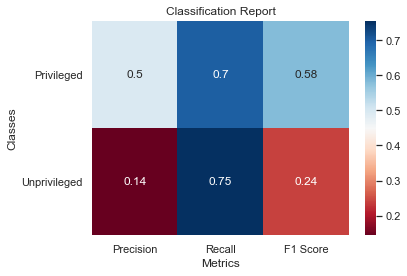

In [164]:
dir_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir2, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'])

## Reweighing + DIR

In [165]:
dir_rw_2 = dir2.copy()
rw = Reweighing(prob_unpriv_group, prob_priv_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7279
Statistical parity difference: -0.0436
Disparate impact: 0.8775
Average odds difference: 0.0419
Equal opportunity difference: 0.0389
Theil index: 0.1246


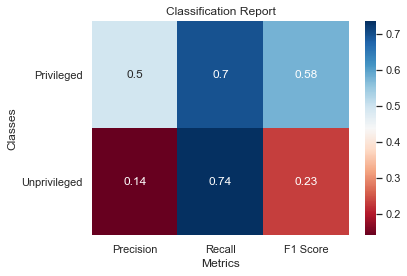

In [166]:
dir_rw_2_class = classify( 
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_rw_2, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'], debiaser=rw)

## Algorithms comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset,-0.3858,0.7622,0.0895,-0.4499,-0.4514,0.1084
DIR,0.0454,0.7296,0.8550,0.0541,-0.0516,0.1236
Reweighed,-0.1362,0.7493,0.3464,-0.1491,-0.2465,0.1225
Reweighing + DIR,0.0419,0.7279,0.8775,0.0389,-0.0436,0.1246
Sampled,-0.0924,0.7409,0.4661,-0.0916,-0.2170,0.1192


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


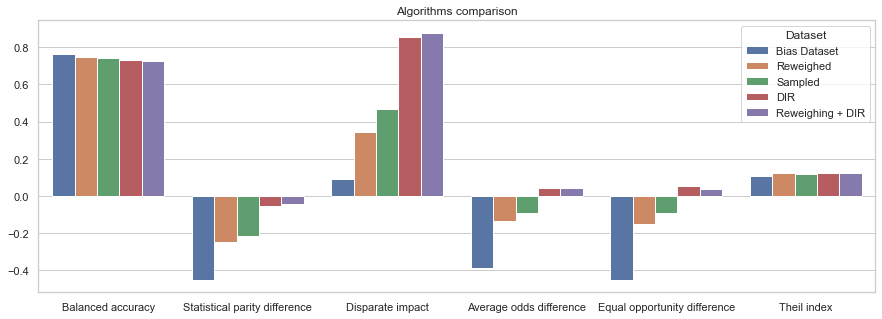

In [167]:
plot_syntesis(merge_datasets({
    'Bias Dataset': df2_class,
    'Reweighed': rw_df2_class,
    'Sampled': sampled_df2_class,
    'DIR': dir_df2_class,
    'Reweighing + DIR': dir_rw_2_class,
}), 'Algorithms comparison')
plt.show()